# Notebooks du stage M1 de Damien 


- Sujet : Micro-lensing avec la candence. 



In [118]:
from astropy import constants as const
from scipy.stats import stats
import scipy.integrate as integrate
from scipy.stats import norm
from scipy import interpolate
from astropy.io import fits
from astropy import units as u
from iminuit import Minuit
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pysynphot as S
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [119]:
%%time

NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0    

graphtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/41g16069m_tmg.fits
 comptable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/49i2235im_tmc.fits
thermtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False
CPU times: user 662 µs, sys: 322 µs, total: 984 µs
Wall time: 716 µs


# Cadence LMC baseline v1

In [120]:
ls ../cadences

cadence_lmc_baseline2018a_extr_v1.csv
cadence_lmc_baseline_2snaps_v1_extr_v1.csv
cadence_lmc_baseline_v1_extr_v1.csv
cadence_lmc_rolling_nm_scale1_extr_v1.csv
cadence_lmc_rolling_scale0_extr_v1.csv


In [121]:
dir_cadences="../cadences"
all_my_cadence_files=["cadence_lmc_baseline2018a_extr_v1.csv",
                      "cadence_lmc_baseline_2snaps_v1_extr_v1.csv",
                      "cadence_lmc_baseline_v1_extr_v1.csv",
                      "cadence_lmc_rolling_nm_scale1_extr_v1.csv",
                      "cadence_lmc_rolling_scale0_extr_v1.csv"
                     ]

In [122]:
#sel_cadence_idx=0  # selectionne la baseline 2018
sel_cadence_idx=2  # selectionne la baseline v1

In [123]:
#cadence_file="Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline_v1.csv"
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])

In [124]:
df = pd.read_csv(cadence_file, index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,934,1,59854.385463,21.593537,y,1.240813,18.077206,1.283730,-1,81.586959,-66.516554
1,935,1,59854.385875,21.550129,y,1.270719,18.030615,1.302205,-1,74.584911,-68.238631
2,936,1,59854.386287,21.510902,y,1.289795,17.976992,1.313900,-1,82.257779,-69.379108
3,937,1,59854.386702,21.432884,y,1.346227,17.894386,1.348096,-1,83.188050,-72.229967
4,939,1,59854.387527,21.434360,y,1.323897,17.867475,1.334634,-1,74.300868,-71.068889
...,...,...,...,...,...,...,...,...,...,...,...
1305,2060368,3447,63269.075104,24.647890,g,1.282391,22.138014,0.978318,-1,85.471063,-68.743581
1306,2065999,3454,63276.044521,23.859685,u,1.297542,22.560035,0.811750,-1,72.500505,-68.644610
1307,2066034,3454,63276.060370,24.815620,g,1.315345,22.118538,0.826568,-1,72.500505,-68.644610
1308,2071175,3461,63283.099369,22.897114,z,1.374037,18.911443,0.861073,-1,90.568361,-71.300651


# Histograms
Comme il y a plusieurs cadences, tu peux comparer ces histogrammes pour plusieurs cadence pour avoir une idée
sur les meilleurs


## SkyNrightness

<span style="color:red"> **Attention, ici il faut séparer le sky brightness dans differents filtres** </span>

Text(0.5, 0, 'skyBrightness')

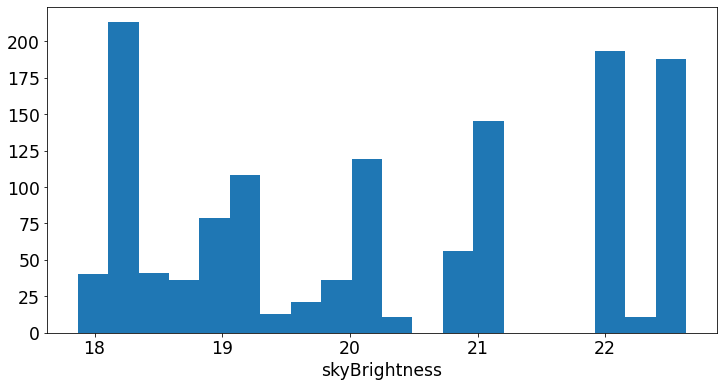

In [125]:
plt.hist(df['skyBrightness'], bins = 20);
plt.xlabel("skyBrightness")

## Field

Text(0.5, 0, 'fieldId')

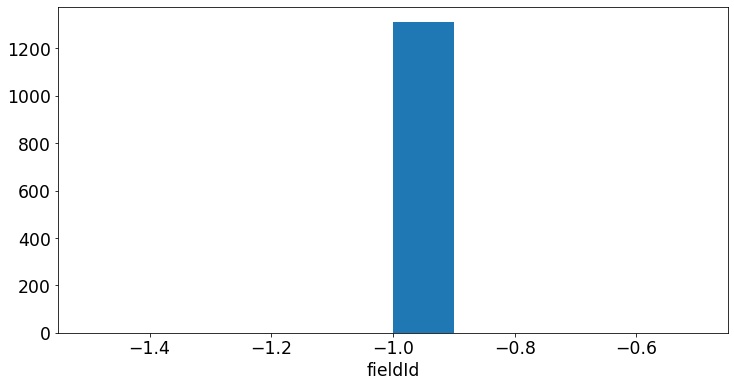

In [126]:
plt.hist(df["fieldId"]);
plt.xlabel("fieldId")

## Airmass


- Plus l'airmass est proche de 1 , plus faibles sont les erreurs photometriques. Y a t'il des differences de distribution en airmass.

- <span style="color:red"> Y a t'il des differences d'airmass entre les differentes cadences ?</span>

Text(0.5, 0, 'airmass')

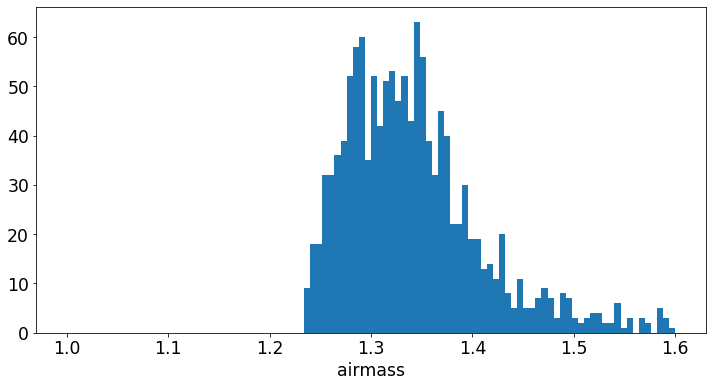

In [127]:
plt.hist(df["airmass"], bins = 100, range=(1,1.6));
plt.xlabel("airmass")

## M5Sigma

- <span style="color:red"> Séparer le M5sigma dans les differents filtres (6 histos differents)</span>
- <span style="color:red"> Y a t'il des differences de M5Sigma entre les differentes cadences ?</span>

Text(0.5, 0, 'fiveSigmaDepth')

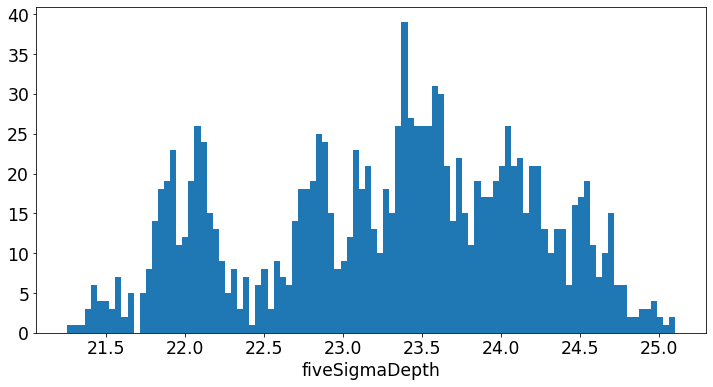

In [128]:
plt.hist(df["fiveSigmaDepth"], bins = 100);
plt.xlabel("fiveSigmaDepth")

# Simulation des parametres de miro-lensing

## t0 distribution

CPU times: user 2.27 s, sys: 66.7 ms, total: 2.33 s
Wall time: 2.34 s


Text(0.5, 1.0, 'Distribution des $t_0$')

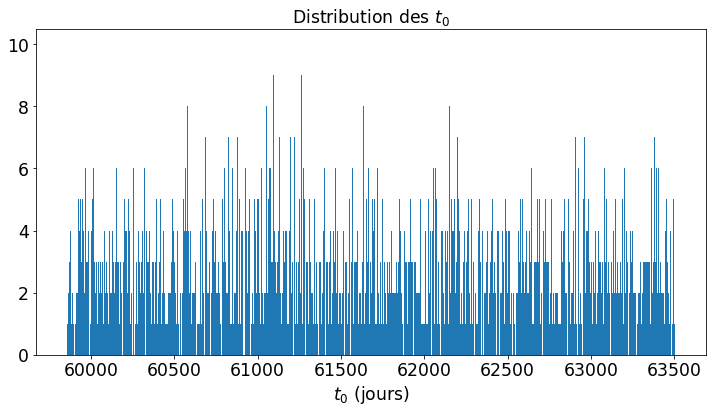

In [129]:
%%time

from scipy.stats import uniform

NYEARS = 10
NDAYS = NYEARS*365.25

xmin = 0
xmax = NDAYS
N=10000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N) + df['observationStartMJD'][0]

plt.hist(list_t0,bins=int(NDAYS));
plt.xlabel("$t_0$ (jours)")
plt.title("Distribution des $t_0$")

## u0 distribution

Text(0.5, 1.0, '$u_{min}$ distribution')

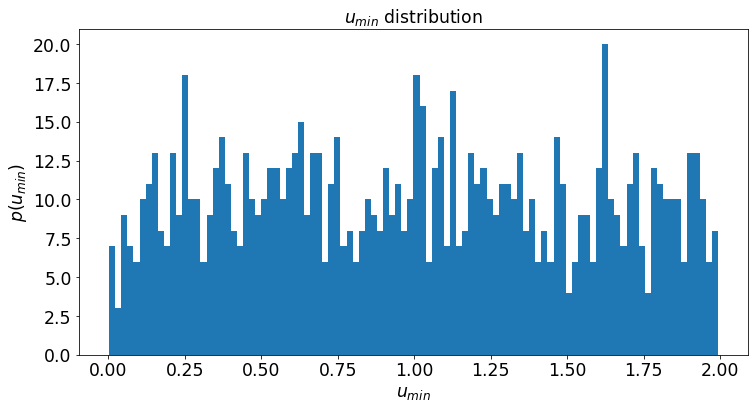

In [130]:
N = 1000
uminmin = 0
uminmax = 2
umin = uniform.rvs(uminmin,uminmax,N)

plt.hist(umin,bins=100)
plt.xlabel("$u_{min}$")
plt.ylabel("$p(u_{min})$")
plt.title("$u_{min}$ distribution")

# Visualisation du LMC sur une carte du ciel

- objectif selectionner un champs fixé pour mesurer l'échantillonnage temporel de la cadence en ce point là.

- Il serait possible de moyenner les calculs ulterieurs sur l'ensemble des régions impliquées

## Define LMC coordinates

In [131]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad

In [132]:
result_table = Simbad.query_object("lmc")

In [133]:
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
print(galaxy_ra,galaxy_dec)

80.89416666666666 -69.75611111111111


### 

 - We only keep data points in a 3.5° field around the center of the LMC

## Visualisation de la région de 3.5° du champs par rapport à l'extension du LMC sur la carte du ciel

- <span style="color:red"> Attention le champs de vue de LSST correspond à un diametre de 3.5° et non un rayon de 3.5° </span>


- En effet on dit que le champs de vue de LSST est de $10°^2$, soit $\theta_x \times \theta_y = 3.5^o \times 3.5^o = 12.5°^2 $ ou mieux $\pi (3.5)^2/4=9.6°^2$

In [134]:
from photutils.aperture import SkyCircularAperture
from regions import CircleSkyRegion

positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg').galactic
aper = SkyCircularAperture(positions, 3.5 * u.deg)
Circle = CircleSkyRegion(positions, 3.5 * u.deg)

In [135]:
data_coords = []
data_coords_u = []
data_coords_g = []
data_coords_r = []
data_coords_i = []
data_coords_z = []
data_coords_y = []
gal_u = []
gal_g = []
gal_r = []
gal_i = []
gal_z = []
gal_y = []

for i in range (len(df['observationStartMJD'])) :
    
    data_coords.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
    
    if (df["filter"][i] == "u") :
        
        data_coords_u.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_u.append(data_coords[i].galactic)
   
    elif (df["filter"][i] == "g") :
        
        data_coords_g.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_g.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "r") :
        
        data_coords_r.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_r.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "i") :
        
        data_coords_i.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_i.append(data_coords[i].galactic)
           
    elif (df["filter"][i] == "z") :
        
        data_coords_z.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_z.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "y") :
        
        data_coords_y.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_y.append(data_coords[i].galactic)
        

# Sky map of the data points in galactic coordinates 

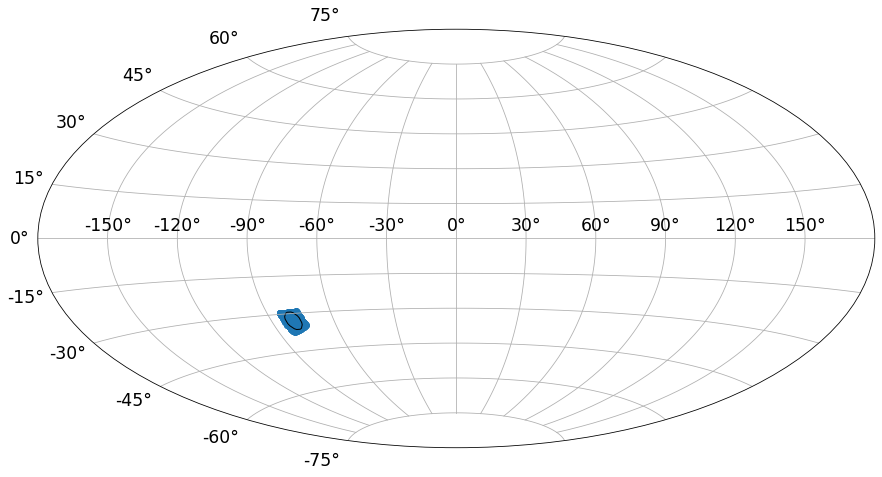

In [136]:
Circle_1 = plt.Circle((positions.l.wrap_at('180d').radian, positions.b.radian), 3.5*np.pi/180, fill = False)
gal = SkyCoord(df['fieldRA'], df['fieldDec'], unit='deg').galactic
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(projection='aitoff')
ax.add_patch(Circle_1)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, color='C0', alpha=1, marker='o')
plt.grid();

# Sky map of the data points in galactic coordinates (with colors for each filters)

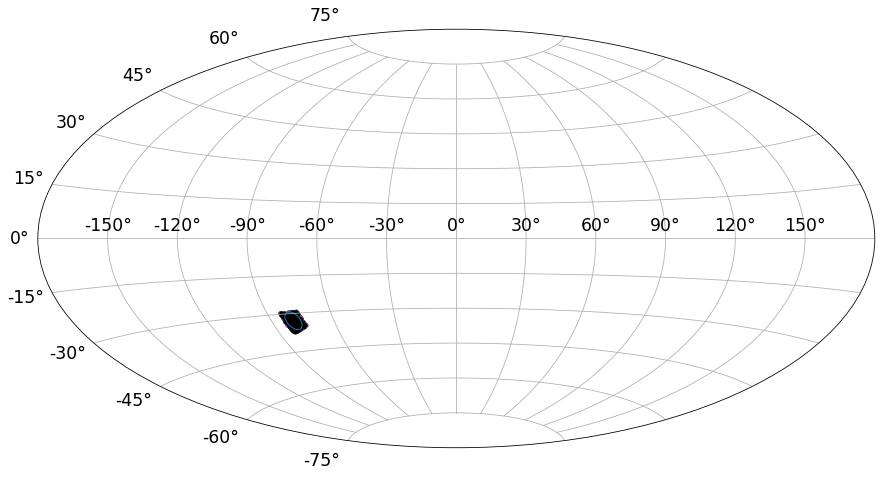

In [137]:
fig = plt.figure(figsize=(15, 10))
Circle_1 = plt.Circle((positions.l.wrap_at('180d').radian, positions.b.radian), 3.5*np.pi/180, fill = False, color ='C0')
ax = plt.subplot(projection='aitoff')
ax.add_patch(Circle_1)

for i in range (len(gal_u)) :

    plt.scatter(gal_u[i].l.wrap_at('180d').radian, gal_u[i].b.radian, color ='b', alpha=1, marker='.')
    
for i in range (len(gal_g)) :
    
    plt.scatter(gal_g[i].l.wrap_at('180d').radian, gal_g[i].b.radian, color = "g", alpha=1, marker='.')
    
for i in range (len(gal_r)) :
    
    plt.scatter(gal_r[i].l.wrap_at('180d').radian, gal_r[i].b.radian, color = "r", alpha=1, marker='.')
    
for i in range (len(gal_i)) :
    
    plt.scatter(gal_i[i].l.wrap_at('180d').radian, gal_i[i].b.radian, color = "blueviolet", alpha=1, marker='.')
    
for i in range (len(gal_z)) :
    
    plt.scatter(gal_z[i].l.wrap_at('180d').radian, gal_z[i].b.radian, color = "grey", alpha=1, marker='.')
    
for i in range (len(gal_y)) :
    
    plt.scatter(gal_y[i].l.wrap_at('180d').radian, gal_y[i].b.radian, color = "k", alpha=1, marker='.')

plt.grid();

In [138]:
from astropy.wcs import WCS

In [139]:
FLAG_SPECIAL_FIT_FILE=False
if FLAG_SPECIAL_FIT_FILE:
    File = fits.open(r'D:\Projet de recherche\Stage\skv20135441655710.fits')

    image = File[0].data
    header = File[0].header
    wcs = WCS(header)

In [140]:
if FLAG_SPECIAL_FIT_FILE:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection = wcs)
    #plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')
    #Circle_2 = plt.Circle((galaxy_ra, galaxy_dec), 3.5, fill = False, color ='C0')
    #ax.add_patch(Circle_2)

    for i in range (len(df['observationId'])) :

        if (df['filter'][i] == "u") :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='o')
        
        if (df['filter'][i] == "g") :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='o')
        
        if (df['filter'][i] == "r") :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='o')
        
        if (df['filter'][i] == "i") :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='o')
        
        if (df['filter'][i] == "z") :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='o')
        
        if (df['filter'][i] == "y") :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='o')
    
    #ax.plot_coord(SkyCoord(galaxy_ra * u.deg, galaxy_dec * u.deg), marker = 'o')   
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')

    overlay = ax.get_coords_overlay('icrs')
    
    overlay.grid(color='blue', ls='dotted')

In [141]:
df_test = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]

In [142]:
if FLAG_SPECIAL_FIT_FILE:

    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection = wcs)
    plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')   
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')


    for i in range (len(df['observationId'])) :

        if (df['filter'][i] == 'u' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='o')
        
        if (df['filter'][i] == 'g' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='o')
        
        if (df['filter'][i] == 'r' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='o')
        
        if (df['filter'][i] == 'i' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='o')
        
        if (df['filter'][i] == 'z' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='o')
        
        if (df['filter'][i] == 'y' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='o')
        
# 7.5° image

In [143]:
if FLAG_SPECIAL_FIT_FILE:
    
    File_big = fits.open(r'D:\Projet de recherche\Stage\skv20134946561546.fits')

    image_big = File_big[0].data
    header_big = File_big[0].header
    wcs_big = WCS(header_big)

    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection = wcs_big)
    plt.imshow(image_big, origin='lower', cmap='cividis', aspect='equal')   
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')


    for i in range (len(df['observationId'])) :

        if (df['filter'][i] == 'u' ):
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='.')
        
        if (df['filter'][i] == 'g'  ):
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='.')
        
        if (df['filter'][i] == 'r'  ):
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='.')
        
        if (df['filter'][i] == 'i'  ):
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='.')
        
        if (df['filter'][i] == 'z' ) :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='.')
        
        if (df['filter'][i] == 'y')  :
        
            ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='.')

# Plot of the data points coordinates (RA, Dec) and the LSST field of view ( 3.5° circle around the center of the LMC)

Text(0, 0.5, 'Declination')

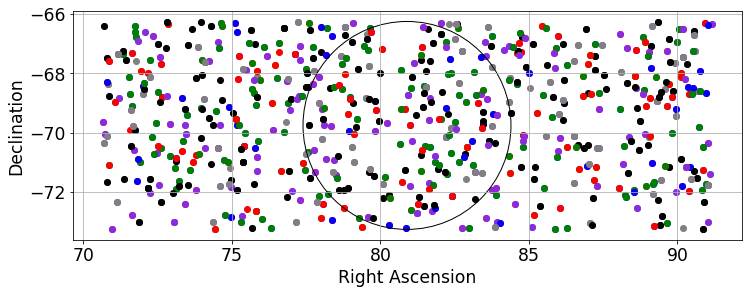

In [144]:
Circle_3 = plt.Circle((galaxy_ra, galaxy_dec), 3.5, fill = False)
fig, ax = plt.subplots() 

for i in range (len(df['observationStartMJD'])) :
    
    if (df["filter"][i] == "u") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'b', marker = 'o')
   
    elif (df["filter"][i] == "g") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'g', marker = 'o')
        
    elif (df["filter"][i] == "r") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'r', marker = 'o')
        
    elif (df["filter"][i] == "i") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'blueviolet', marker = 'o')
           
    elif (df["filter"][i] == "z") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'grey', marker = 'o')
        
    elif (df["filter"][i] == "y") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'k', marker = 'o')
        


ax.add_patch(Circle_3)
ax.set_aspect("equal")
ax.grid()
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

# We only keep the data points inside the LSST field of view  

Text(0, 0.5, 'Declination')

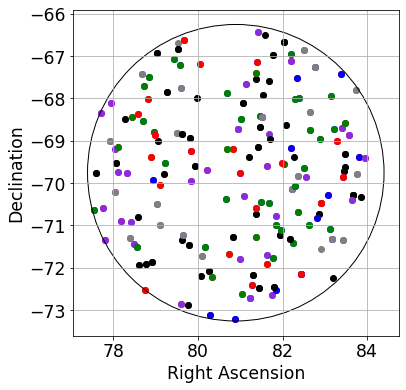

In [145]:
Circle_3 = plt.Circle((galaxy_ra, galaxy_dec), 3.5, fill = False)
fig, ax = plt.subplots() 

for i in range (len(df_test['observationStartMJD'])) :
    
    if (df_test["filter"].values[i] == "u") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'b', marker = 'o')
   
    elif (df_test["filter"].values[i] == "g") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'g', marker = 'o')
        
    elif (df_test["filter"].values[i] == "r") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'r', marker = 'o')
        
    elif (df_test["filter"].values[i] == "i") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'blueviolet', marker = 'o')
           
    elif (df_test["filter"].values[i] == "z") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'grey', marker = 'o')
        
    elif (df_test["filter"].values[i] == "y") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'k', marker = 'o')
        
ax.add_patch(Circle_3)
ax.set_aspect("equal")
ax.grid()
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

# Relative angular source-lens separation u(t)

$$ 
   u(t) = \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)}
$$




In [146]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

# Amplitude as a function of u(t)

$$
    A(u) = \frac{u^2 + 2}{u\sqrt{u^2 + 4}}
$$

In [147]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

# Amplitude as a function of u0, t0, tE

$$
    A(t, u_0, t_0, t_E) = \frac{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 2}{\sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)} \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 4}}
$$

In [148]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4) 

# Gaussian

$$
    y = \frac{A}{\sigma \sqrt{2\pi}} e^{\frac{-(x - \mu)^2}{2\sigma^2}}
$$

In [149]:
#Gaussian fit

def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

# Linear 

$$
    y = \alpha x + \beta
$$


In [150]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

# Plotting the light curve and Microlensing fit with arbitrary errors

t0 = 62141.472809798084
tE = 20
u0 = 1.7308699048363447


(62041.472809798084, 62241.472809798084)

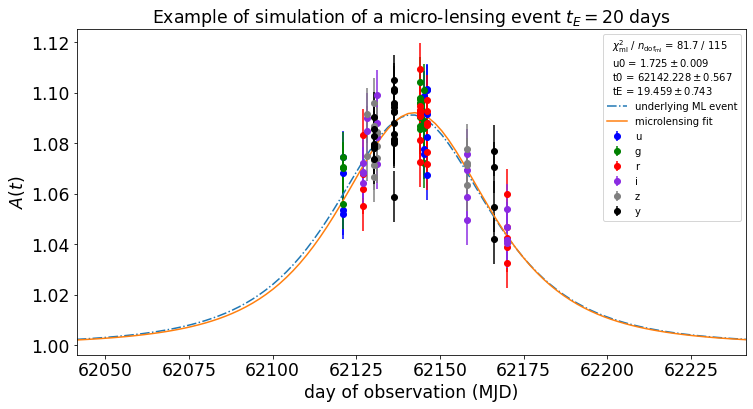

In [151]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Plot

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")
#plt.scatter(df_event_times,A(u(df_event_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_u_times,A(u(df_event_u_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_g_times,A(u(df_event_g_times)),marker="o",s=20,color = "g",label="g")
#plt.scatter(df_event_r_times,A(u(df_event_r_times)),marker="o",s=20,color = "r",label="r")
#plt.scatter(df_event_i_times,A(u(df_event_i_times)),marker="o",s=20,color ="blueviolet",label="i")
#plt.scatter(df_event_z_times,A(u(df_event_z_times)),marker="o",s=20,color ="grey",label="z")
#plt.scatter(df_event_y_times,A(u(df_event_y_times)),marker="o",s=20,color="k",label="y")

# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y_noise = 0.01

y = y_data + y_noise * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + y_noise * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + y_noise * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + y_noise * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + y_noise * np.random.randn(len(x_i)) 
y_z = A(u(df_event_times_z)) + y_noise * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + y_noise * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, y_noise, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

# Linear fit

(62041.472809798084, 62241.472809798084)

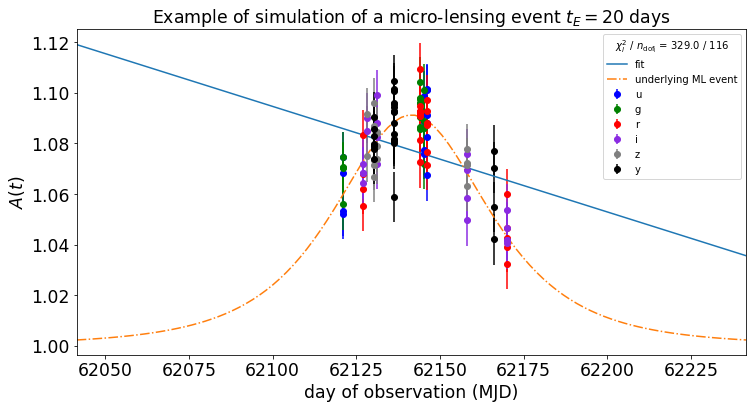

In [152]:
least_squares_line = LeastSquares(x, y, y_noise, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [153]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

16.308696295152483

# Test error on magnitude

In [154]:

m = 20
xerr = []
sigma_sys = 0.003
error_photo = []


for i in range (len(df)) :
    
    xerr.append( 10**(0.4*(m - df["fiveSigmaDepth"][i])))
    
    if (df["filter"][i] == "u") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.037) * xerr[i] + 0.037 * xerr[i]**2))  
   
    elif (df["filter"][i] == "g") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.038) * xerr[i] + 0.038 * xerr[i]**2))  
        
    elif (df["filter"][i] == "r") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))  
        
    elif (df["filter"][i] == "i") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))      
           
    elif (df["filter"][i] == "z") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))     
        
    elif (df["filter"][i] == "y") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))
        


# Photo error as a function of magnitude

Text(0.5, 1.0, 'Photometric error as a function of magnitude')

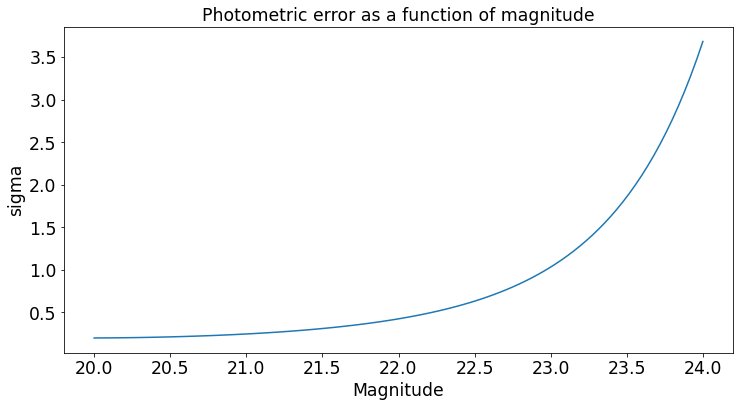

In [155]:
mag = np.linspace(20,24,100)
sigma = []

for i in range (len(mag)) :
    
    sigma.append(np.sqrt(sigma_sys**2 + (0.04 - 0.037) * 10**(0.4*(mag[i] - 20)) + 0.037 * 10**(0.4*(mag[i] - 20))**2))

    
plt.plot(mag,sigma)
plt.xlabel("Magnitude")
plt.ylabel("sigma")
plt.title("Photometric error as a function of magnitude")
#plt.text(x = 21, y = 3, s = "Low magnitude/Bright source means high photometric error", fontsize = 15, color = 'r')

# Background noise

$$
    F_b = F_{ab}10^{-0.4m_b} \times \pi \theta_{seeing}^2 
$$

$$
     F_{ab} = 3631 Jy = 3631\times10^{-23} erg.s^{-1}.Hz^{-1}.cm^{-2} = 3631\times10^{-26} W.Hz^{-1}.m^{-2}
$$

$$
    N_{pe}^b = \frac{\pi D^2 \Delta T}{4h}F_b \int_{}^{} T^{syst}_b(\lambda) \,\frac{d\lambda}{\lambda} 
$$

In [163]:
throughput_file="../throughput/lsst_throughput.csv"

In [164]:
#df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)
df_LSST = pd.read_csv(throughput_file, index_col=0)

In [165]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

In [166]:
ObservationStartMJD_u = []
ObservationStartMJD_g = []
ObservationStartMJD_r = []
ObservationStartMJD_i = []
ObservationStartMJD_z = []
ObservationStartMJD_y = []

for i in range (len(df["observationId"])) :
    
    if (df['filter'][i] == 'u') :
            
            ObservationStartMJD_u.append(df["observationStartMJD"].values[i])
    
    if (df['filter'][i] == 'g') :
            
            ObservationStartMJD_g.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'r') :
            
            ObservationStartMJD_r.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'i') :
            
            ObservationStartMJD_i.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'z') :
            
            ObservationStartMJD_z.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'y') :
        
            ObservationStartMJD_y.append(df["observationStartMJD"].values[i])

In [167]:
from astropy import units as u

D = Deff
Delta_T = EXPOSURE
F_ab = 3631*10**(-23) * u.erg/u.s/u.Hz/u.cm**2

In [168]:
F_ab.to(u.jansky)

<Quantity 3631. Jy>

In [169]:
H = S.units.H * (u.erg * u.s)
H

<Quantity 6.6262e-27 erg s>

In [170]:
F_b = []
F_b_u = []
F_b_g = []
F_b_r = []
F_b_i = []
F_b_z = []
F_b_y = []

for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
    
    if (df['filter'][i] == 'u') :
            
            F_b_u.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
    
    if (df['filter'][i] == 'g') :
            
            F_b_g.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'r') :
            
            F_b_r.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'i') :
            
            F_b_i.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'z') :
            
            F_b_z.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'y') :
        
            F_b_y.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

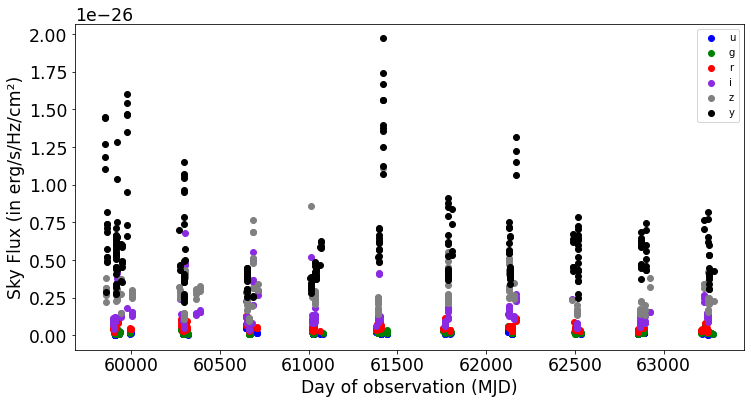

In [171]:
plt.scatter(ObservationStartMJD_u, F_b_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, F_b_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, F_b_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, F_b_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, F_b_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, F_b_y, color = 'k', label = 'y')
plt.ylabel("Sky Flux (in erg/s/Hz/cm²)")
plt.xlabel("Day of observation (MJD)")
plt.legend()

In [172]:
N_pe = []
N_pe_u = []
N_pe_g = []
N_pe_r = []
N_pe_i = []
N_pe_z = []
N_pe_y = []

for i in range (len(F_b)) :
    
    if (df['filter'][i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
            N_pe_u.append(N_pe[i])
    
    if (df['filter'][i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            N_pe_g.append(N_pe[i])
            
    if (df['filter'][i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            N_pe_r.append(N_pe[i])
            
    if (df['filter'][i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            N_pe_i.append(N_pe[i])
            
    if (df['filter'][i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            N_pe_z.append(N_pe[i])
            
    if (df['filter'][i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))
            N_pe_y.append(N_pe[i])


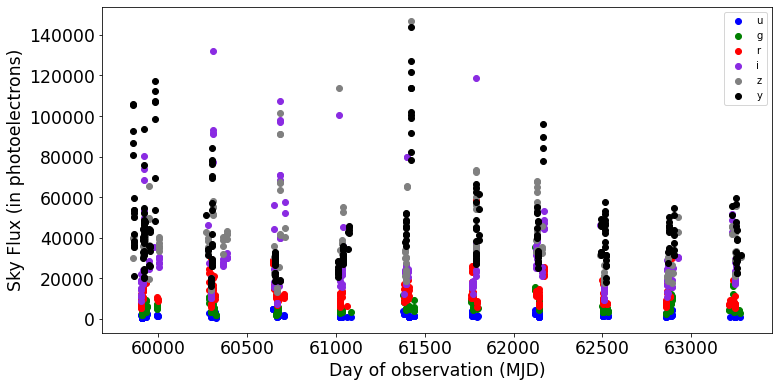

In [173]:
plt.scatter(ObservationStartMJD_u, N_pe_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, N_pe_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, N_pe_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, N_pe_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, N_pe_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, N_pe_y, color = 'k', label = 'y')
plt.ylabel("Sky Flux (in photoelectrons)")
plt.xlabel("Day of observation (MJD)")
plt.legend()

In [ ]:
#import scipy.integrate as integrate
#a = 0

#for i in range (len(LSST_u.throughput)) :
    
    #a = integrate.quad(lambda Wavelength: LSST_u.throughput[i]/Wavelength, 3000, 12000)
    
#a

In [174]:
integrate.trapz(LSST_u.throughput/Wavelength)

0.006519157490141833

In [175]:
a = 0

for i in range (len(LSST_u.throughput)) :
    
    a = a + LSST_u.throughput[i]/Wavelength[i]
    
a

0.006519276406808502

In [176]:
agk_81d266 = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'agk_81d266_stisnic_007.fits')

agk_81d266_spec = S.FileSpectrum(agk_81d266).renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

agk_81d266_spec.convert('count')

(0.0, 6000.0)

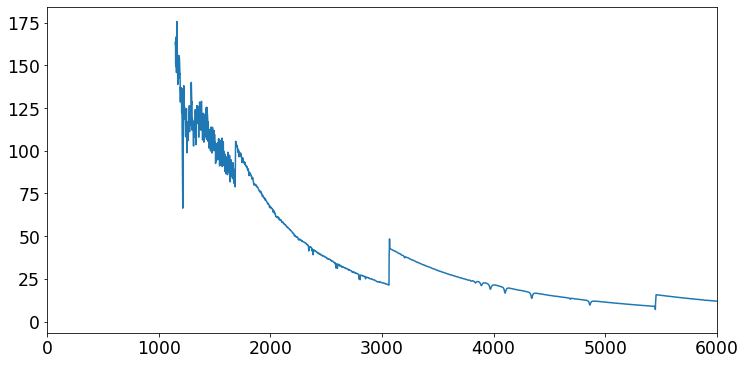

In [177]:
plt.plot(agk_81d266_spec.wave, agk_81d266_spec.flux)
plt.xlim([0,6000])

# Atmospheric throughput for every observation

In [179]:
! ls

Fit only.ipynb                        PySynphot.ipynb
Internship.ipynb                      Test chi2 ndof for different tE.ipynb
Internship_corr.ipynb                 Test fit + chi2.ipynb


In [178]:
import transmission as t

t.atmo(4959,1.2584)

ModuleNotFoundError: No module named 'transmission'

In [ ]:
df_2018a = pd.read_csv(r'D:\Projet de recherche\Stage\Baseline_LMCv1_Atmosphere.csv')
df_2018a

In [ ]:
bp_atmo = []

for i in range (len(df['observationId'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_2018a.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)

In [ ]:
all_bp = []
all_bp_u = []
all_bp_g = []
all_bp_r = []
all_bp_i = []
all_bp_z = []
all_bp_y = []

for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        all_bp_u.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
        all_bp_g.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
        all_bp_r.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
        all_bp_i.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
        all_bp_z.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)
        all_bp_y.append(bp)

# Define the source spectrum below

In [ ]:
Spec = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

In [ ]:
all_obs = []

for bp in all_bp :
    
    obs = S.Observation(Spec, bp);
    all_obs.append(obs);

In [ ]:
all_obs_u = []
all_obs_g = []
all_obs_r = []
all_obs_i = []
all_obs_z = []
all_obs_y = []

for bp in all_bp_u :
    
    obs_u = S.Observation(Spec, bp);
    all_obs_u.append(obs_u);
    
for bp in all_bp_g :
    
    obs_g = S.Observation(Spec, bp);
    all_obs_g.append(obs_g);
    
for bp in all_bp_r :
    
    obs_r = S.Observation(Spec, bp);
    all_obs_r.append(obs_r);
    
for bp in all_bp_i :
    
    obs_i = S.Observation(Spec, bp);
    all_obs_i.append(obs_i);
    
for bp in all_bp_z :
    
    obs_z = S.Observation(Spec, bp);
    all_obs_z.append(obs_z);
    
for bp in all_bp_y :
    
    obs_y = S.Observation(Spec, bp);
    all_obs_y.append(obs_y);

In [ ]:
%%time

all_count = []
all_count_u = []
all_count_g = []
all_count_r = []
all_count_i = []
all_count_z = []
all_count_y = []
idx = 0

for obs in all_obs :
    
    all_count.append(obs.countrate()*EXPOSURE)
    
for obs_u in all_obs_u :
    
    all_count_u.append(obs_u.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0

for obs_g in all_obs_g :
    
    all_count_g.append(obs_g.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_r in all_obs_r :
    
    all_count_r.append(obs_r.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_i in all_obs_i :
    
    all_count_i.append(obs_i.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_z in all_obs_z :
    
    all_count_z.append(obs_z.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_y in all_obs_y :
    
    all_count_y.append(obs_y.countrate()*EXPOSURE)
    idx += 1
    
print(idx)

In [ ]:
max(all_count_r)

In [ ]:
plt.scatter(N_pe_u, all_count_u, color = 'b', label = 'u')
plt.scatter(N_pe_g, all_count_g, color = 'g', label = 'g')
plt.scatter(N_pe_r, all_count_r, color = 'r', label = 'r')
plt.scatter(N_pe_i, all_count_i, color = 'blueviolet', label = 'i')
plt.scatter(N_pe_z, all_count_z, color = 'grey', label = 'z')
plt.scatter(N_pe_y, all_count_y, color = 'k', label = 'y')
plt.xlabel("Sky noise")
plt.ylabel("Photoelectrons")
plt.legend()

# Photometric error

$$
    N = \sqrt{N_{pe} + F}
$$

where 

$N_{pe}$ is the background noise 

F is the source flux  

N the photometric error

In [ ]:
N = []
N_u = []
N_g = []
N_r = []
N_i = []
N_z = []
N_y = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))
    
for i in range (len(N_pe_u)) :
    
    N_u.append(np.sqrt(N_pe_u[i] + all_count_u[i]))
    
for i in range (len(N_pe_g)) :
    
    N_g.append(np.sqrt(N_pe_g[i] + all_count_g[i]))
    
for i in range (len(N_pe_r)) :
    
    N_r.append(np.sqrt(N_pe_r[i] + all_count_r[i]))
    
for i in range (len(N_pe_i)) :
    
    N_i.append(np.sqrt(N_pe_i[i] + all_count_i[i]))
    
for i in range (len(N_pe_z)) :
    
    N_z.append(np.sqrt(N_pe_z[i] + all_count_z[i]))
    
for i in range (len(N_pe_y)) :
    
    N_y.append(np.sqrt(N_pe_y[i] + all_count_y[i]))

In [ ]:
plt.scatter(ObservationStartMJD_u, N_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, N_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, N_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, N_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, N_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, N_y, color = 'k', label = 'y')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Photometric error")
plt.legend()

In [ ]:
plt.errorbar(ObservationStartMJD_u, all_count_u, N_u, fmt="o", color = 'b')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the u band (with photometric errors)")

In [ ]:
plt.errorbar(ObservationStartMJD_g, all_count_g, N_g, fmt="o", color = 'g')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the g band (with photometric errors)")

In [ ]:
plt.errorbar(ObservationStartMJD_r, all_count_r, N_r, fmt="o", color = 'r')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the r band (with photometric errors)")

In [ ]:
plt.errorbar(ObservationStartMJD_i, all_count_i, N_i, fmt="o", color = 'blueviolet')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the i band (with photometric errors)")

In [ ]:
plt.errorbar(ObservationStartMJD_z, all_count_z, N_z, fmt="o", color = 'grey')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the z band (with photometric errors)")

In [ ]:
plt.errorbar(ObservationStartMJD_y, all_count_y, N_y, fmt="o", color = 'k')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the y band (with photometric errors)")

# Amplitude error

$$
\sigma_A = \frac{\sigma_N \times A(t)}{F}
$$

In [ ]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [ ]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [ ]:
amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(all_count)) :
    
    amp_err.append(N[i] * A(u(df['observationStartMJD'][i]))/all_count[i])

for i in range (len(all_count_u)) :
        
    amp_err_u.append(N_u[i] * A(u(ObservationStartMJD_u[i]))/all_count_u[i])
        
for i in range (len(all_count_g)) :
        
    amp_err_g.append(N_g[i] * A(u(ObservationStartMJD_g[i]))/all_count_g[i])
    
for i in range (len(all_count_r)) :
        
    amp_err_r.append(N_r[i] * A(u(ObservationStartMJD_r[i]))/all_count_r[i])
    
for i in range (len(all_count_i)) :
        
    amp_err_i.append(N_i[i] * A(u(ObservationStartMJD_i[i]))/all_count_i[i])
    
for i in range (len(all_count_z)) :
        
    amp_err_z.append(N_z[i] * A(u(ObservationStartMJD_z[i]))/all_count_z[i])
    
for i in range (len(all_count_y)) :
        
    amp_err_y.append(N_y[i] * A(u(ObservationStartMJD_y[i]))/all_count_y[i])


In [ ]:
plt.scatter(ObservationStartMJD_u, amp_err_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, amp_err_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, amp_err_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, amp_err_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, amp_err_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, amp_err_y, color = 'k', label = 'y')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Error on the amplitude")
plt.legend()

# Plotting the light curve and Microlensing fit with expected errors

In [ ]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 200

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Photometric Error


    

amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(df['observationStartMJD'])) :
    
    if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        amp_err.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    
        if (df['filter'].values[i] == 'u') :
        
            
            amp_err_u.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
       
        if (df['filter'].values[i] == 'g') :
        
            
            amp_err_g.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'r') :
        
            
            amp_err_r.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'i') :
        
            
            amp_err_i.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'z') :
        
            
            amp_err_z.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'y') :
        
            
            amp_err_y.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    



#Plot

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")
#plt.scatter(df_event_times,A(u(df_event_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_u_times,A(u(df_event_u_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_g_times,A(u(df_event_g_times)),marker="o",s=20,color = "g",label="g")
#plt.scatter(df_event_r_times,A(u(df_event_r_times)),marker="o",s=20,color = "r",label="r")
#plt.scatter(df_event_i_times,A(u(df_event_i_times)),marker="o",s=20,color ="blueviolet",label="i")
#plt.scatter(df_event_z_times,A(u(df_event_z_times)),marker="o",s=20,color ="grey",label="z")
#plt.scatter(df_event_y_times,A(u(df_event_y_times)),marker="o",s=20,color="k",label="y")

# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y = y_data + amp_err * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + amp_err_u * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + amp_err_g * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + amp_err_r * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + amp_err_i * np.random.randn(len(x_i))
y_z = A(u(df_event_times_z)) + amp_err_z * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + amp_err_y * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, amp_err, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [ ]:
least_squares_line = LeastSquares(x, y, amp_err, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [ ]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 